### Text classifier (a simple sentiment classifier ) using Large Movie Review Dataset

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
print ("Packages loaded.")

Packages loaded.


### Get dataset

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
        extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
    return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,The Straight Story is a multilevel exploration...,10,1
1,I really liked this movie. Of course the idea ...,9,1
2,If you have ever seen a movie by Brian Avenet-...,1,0
3,If you delete the first twenty minutes or so o...,7,1
4,"Oh dear, Oh dear. I started watching this not ...",1,0


In [3]:
train_df['sentence']

0        The Straight Story is a multilevel exploration...
1        I really liked this movie. Of course the idea ...
2        If you have ever seen a movie by Brian Avenet-...
3        If you delete the first twenty minutes or so o...
4        Oh dear, Oh dear. I started watching this not ...
5        Pretty disappointing prequel to the first two ...
6        I saw the The Bourne Ultimatum last summer wit...
7        Sondra Locke stinks in this film, but then she...
8        This is the worst sequel on the face of the wo...
9        This movie had to be the worst horror movie I ...
10       I loved the story. Somewhere, a poster said th...
11       Not sure why this film was advertised as a wil...
12       Okay so i found out about this movie and I wat...
13       Why this movie has all but disappeared into ob...
14       Steven Spielberg (at 24) had already directed ...
15       Spacecamp is my favorite movie. It is a great ...
16       I've never actually seen this film but can tel.

In [4]:
train_df['polarity']

0        1
1        1
2        0
3        1
4        0
5        0
6        1
7        0
8        0
9        0
10       1
11       0
12       0
13       1
14       1
15       1
16       0
17       0
18       1
19       0
20       1
21       0
22       1
23       0
24       0
25       1
26       0
27       0
28       1
29       1
        ..
24970    0
24971    0
24972    0
24973    1
24974    0
24975    1
24976    0
24977    1
24978    0
24979    1
24980    1
24981    0
24982    0
24983    1
24984    1
24985    1
24986    0
24987    0
24988    0
24989    0
24990    1
24991    1
24992    0
24993    0
24994    1
24995    0
24996    0
24997    1
24998    1
24999    1
Name: polarity, Length: 25000, dtype: int64

### Model

In [5]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)
# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

### Get feature

In [6]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

### Estimator

In [7]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

### Training

In [8]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000)
print ("Done.")

Done.


### Prediction

In [9]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8001599907875061
Test set accuracy: 0.7898399829864502


###  Confusion matrix

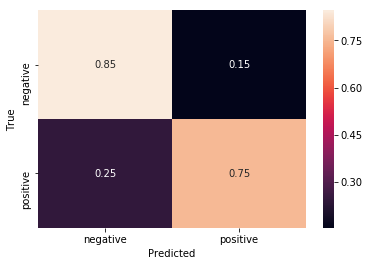

In [10]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"], 
                           get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");